<a href="https://colab.research.google.com/github/shaharinv/ML-PROJECT-/blob/DL-PROJECTS/leaf_disesase_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('user uploaded file "(name)" with length (length) bytes'.format(name=fn, length=len(uploaded[fn])))

# then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sumanrathaur/potato-disease

Dataset URL: https://www.kaggle.com/datasets/sumanrathaur/potato-disease
License(s): unknown
 24% 9.00M/37.9M [00:00<00:01, 23.1MB/s]
100% 37.9M/37.9M [00:00<00:00, 80.9MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/potato-disease.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


importing the dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


Double-click (or enter) to edit

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Potato Plant Disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]



As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

Visualize some of the images from our dataset

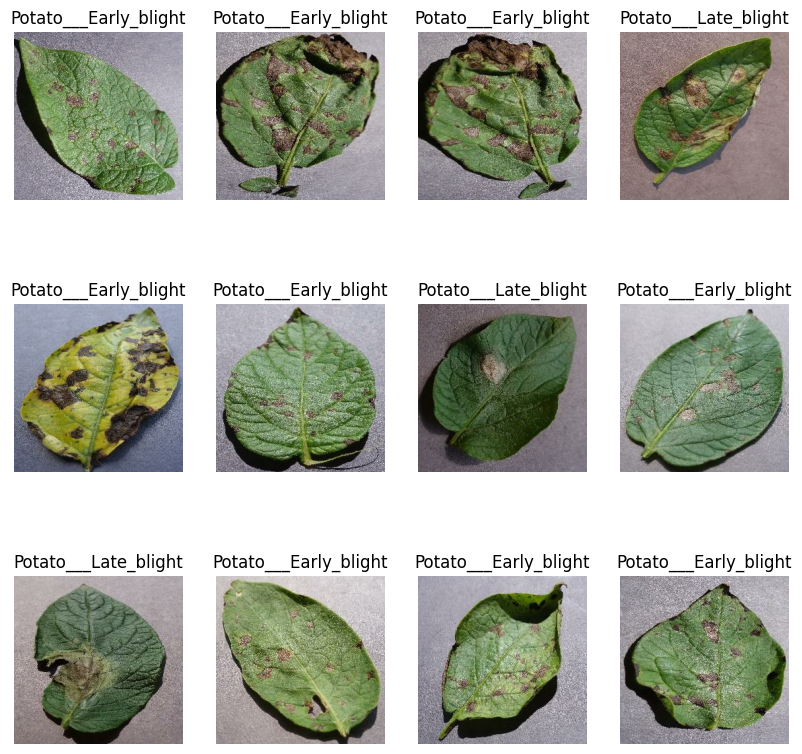

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:


Training: Dataset to be used while training


Validation: Dataset to be tested against while training


Test: Dataset to be tested against after we trained a model


80%===> training 20%===> 10% validatio,10% test

In [ ]:
len(dataset)

68

In [ ]:
train_size=0.8
len(dataset)*train_size


54.400000000000006

In [ ]:
 train_ds=dataset.take(54)
 len(train_ds)

54

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000 ):

  ds_size= len(ds)

  if shuffle:
     ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

pre processing

Creating a Layer for Resizing and Normalization


Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.






In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.



In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

MODEL BUILDING

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:

model.compile(
    optimizer=  'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 227s 4s/step - loss: 0.9184 - accuracy: 0.4821 - val_loss: 0.8720 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 213s 4s/step - loss: 0.8047 - accuracy: 0.5851 - val_loss: 0.6236 - val_accuracy: 0.6615
Epoch 3/50
54/54 [==============================] - 220s 4s/step - loss: 0.4806 - accuracy: 0.7946 - val_loss: 0.4470 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 216s 4s/step - loss: 0.3446 - accuracy: 0.8640 - val_loss: 0.3486 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 220s 4s/step - loss: 0.2073 - accuracy: 0.9207 - val_loss: 0.1378 - val_accuracy: 0.9531
Epoch 6/50
54/54 [==============================] - 221s 4s/step - loss: 0.2535 - accuracy: 0.8953 - val_loss: 0.1683 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 216s 4s/step - loss: 0.0867 - accuracy: 0.9711 - val_loss: 0.1346 - val_accuracy: 0.9271
Epoch 8/50
54

In [ ]:
 scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 26ms/step - loss: 0.0504 - accuracy: 0.9961


In [ ]:
scores

[0.050384487956762314, 0.99609375]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

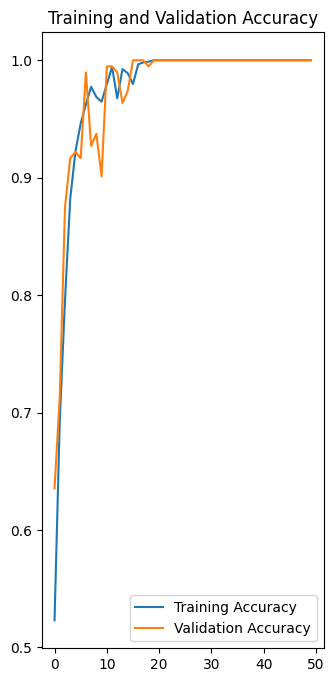

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



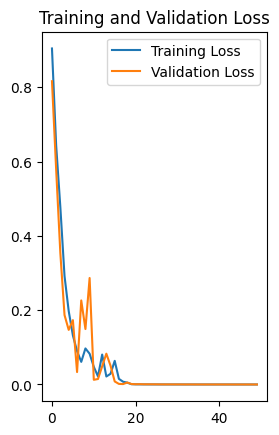

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 28ms/step
predicted label: Potato___Late_blight


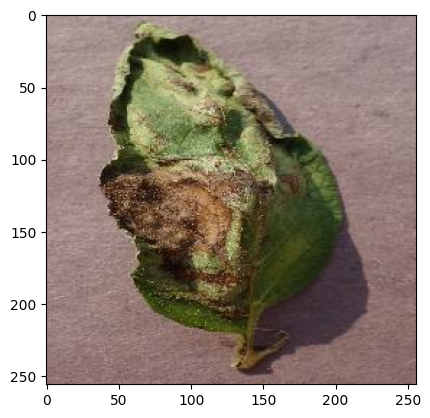

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


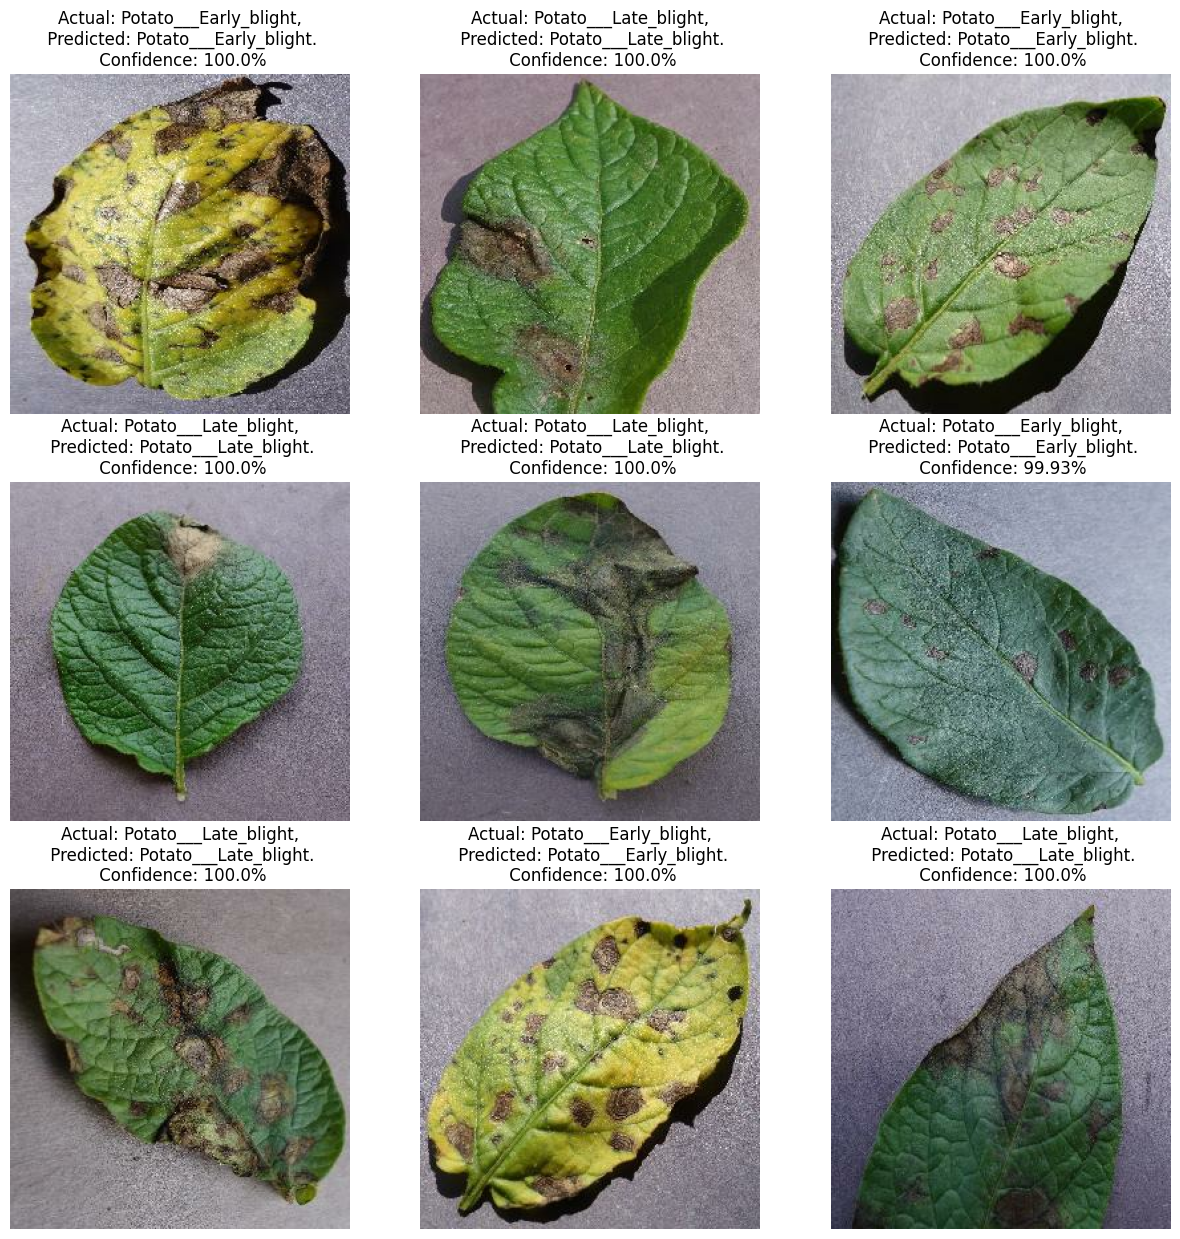

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")